# Example: Static equilibrium calculations

## Inverse and forward Grad-Shafranov solvers
This example notebook shows how to use FreeGSNKE to solve static Grad-Shafranov (GS) problems. Examples are provided for both inverse and forward solve modes. 

By inverse solve mode, we refer to the case in which we seek a set of coil currents such that a user-specified magnetic configuration (i.e. some constraints on the plasma) is satisfied.

By forward solve mode, we refer to the case in which the coil currents and profile parameterisation are chosen by the user and the Grad-Shafranov equation is solved for the equilibrium. 

Below, we illustrate how to use the solvers for both diverted and limited plasma configurations in a **MAST-U-like tokamak** using stored pickle files containing the machine description. These machine description files come from the FreeGS repository.

## Import packages

In [1]:
import os
import matplotlib.pyplot as plt
import freegsfast
import numpy as np

## Create the machine object

First, we build the machine object. This is done using the pickle files saved in the "machine_configs/MAST-U" directory. 

FreeGSNKE requires the following envirnoment variables in order to build the machine: ACTIVE_COILS_PATH, PASSIVE_COILS_PATH, WALL_PATH, LIMITER_PATH, PROBE_PATH (not required here).

In [2]:
# set paths
os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U-like_active_coils.pickle"
os.environ["PASSIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U-like_passive_coils.pickle"
os.environ["WALL_PATH"] = f"../machine_configs/MAST-U/MAST-U-like_wall.pickle"
os.environ["LIMITER_PATH"] = f"../machine_configs/MAST-U/MAST-U-like_limiter.pickle"

In [3]:
# Now the machine can actually be built:
from freegsnke import build_machine
tokamak = build_machine.tokamak()

No probe configuration is provided


## Instantiate an equilibrium

We are now ready to build a plasma equilibrium in the tokamak object. This is done using the `freegsfast.Equilibrium` class, which implicitly defines the rectangular domain of the solver as well as the grid resolution.

`Equilibrium` has sensible defaults, but it is recommended to define the radial and vertical domain of the grid using the `Rmin`, `Rmax`, `Zmin` and `Zmax` parameters, as well as the grid resolution in the radial and vertical directions with the `nx` and `ny` parameters.

A tokamak object should be supplied to the `tokamak` parameter to assign the desired machine to the equilibrium.

If available, an initial plasma flux function can be provided to the `psi` parameter (commented out in the following code).

In [4]:
from freegsnke import equilibrium_update

eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # Radial range
    Zmin=-2.2, Zmax=2.2,  # Vertical range
    nx=65,                # Number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # Number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)  

## Instantiate a profile object

We can now instatiate a profile object that contains the chosen parameterisation of the toroidal plasma current density (i.e. the right hand side of the GS equation). We can then set the paramters for the chosen current density profile(s). 

A number of different profile parameterisations exisit in FreeGSNKE (FreeGSfast) at the moment (more will be added in the future). 

Currently available are:
- `ConstrainPaxisIp` or `ConstrainBetapIp` -- (see [Jeon (2015)](https://link.springer.com/article/10.3938/jkps.67.843))
    - Parameterised as:
 $$J_{p}(\psi, R, Z) = \lambda\big[ \beta_{0} \frac{R}{R_{0}} \left( 1-\psi_{n}^{\alpha_m} \right)^{\alpha_n} + (1-\beta_{0}) \frac{R_0}{R} \left( 1-\psi_{n}^{\alpha_m} \right)^{\alpha_n} \big], $$
where the first term is the pressure profile and the second is the toroidal current profile.
    - Required parameters are `Ip` (total plasma current), `fvac` ($rB_{tor}$, vacuum toroidal field strength), `alpha_m`>0, and `alpha_n`>0 (that define the shape/peakedness of the profiles).
    - If `ConstrainPaxisIp` used then `paxis` (pressure on the magnetic axis) is required.
    - If `ConstrainBetapIp` used then `betap` (proxy of the poloidal beta) is required.
    - The values of $\lambda$ and $\beta_0$ are found using the above parameters as constraints ($R_0$ is a fixed scaling constant).

- `Topeol` -- (see equation 13 in L. L. Lao et al (1985) Nucl. Fusion 25 1611)
    - Parameterised exactly the same way as above except this time we can specify $\beta_0$ directly. 
    - As above, the required parameters are `beta0`, `Ip` (total plasma current), `fvac` ($rB_{tor}$,  vacuum toroidal field strength), `alpha_m`>0, and `alpha_n`>0 (that define the shape/peakedness of the profiles).
       
- `Lao85` -- (see equations 4 and 5 in L. L. Lao et al (1985) Nucl. Fusion 25 1611)
    - Parameterised as:
 $$J_{p}(\psi, R, Z) = \lambda\big[ \frac{R}{R_{0}} p'(\psi_n) + \frac{R_0}{R} \frac{1}{\mu_0} F F'(\psi_n) \big], $$
where the pressure and toroidal current profiles are given by
$$ p'(\psi_n) = \sum_{i=0}^{n_p} \alpha_i \psi_n^i - \hat{\alpha} \psi_n^{n_p + 1} \sum_{i=0}^{n_p} \alpha_i$$
and
$$ F F'(\psi_n) = \sum_{i=0}^{n_F} \beta_i \psi_n^i - \hat{\beta} \psi_n^{n_F + 1} \sum_{i=0}^{n_F} \beta_i.$$ 
    - Required parameters are `Ip` (total plasma current), `fvac` ($rB_{tor}$,  vacuum toroidal field strength), `alpha` (array of alpha coefficients), `beta` (array of beta coefficients), `alpha_logic`, and `beta_logic` (Booleans that correspond to $\hat{\alpha}$ and $\hat{\beta}$ above, sets boundary condition for plasma current at plasma boundary).
    - The value of $\lambda$ is found using the above parameters as constraints (the magnetic permeability $\mu_0$ is defined in FreeGSNKE).

Note: $\psi_n$ denotes the normalised flux. 

We will use the `ConstrainPaxisIp` option here (the others are specfied as examples - may not work with the given parameters).

Equilibrium (`eq`) and limiter (`tokamak.limiter`) objects are passed to the profile to inform calculations relating to the limiter.

In [5]:
# initialise the profiles
from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(
    eq=eq,        # equilibrium object
    paxis=8e3,    # profile object
    Ip=6e5,       # plasma current
    fvac=0.5,     # fvac = rB_{tor}
    alpha_m=1.8,  # profile function parameter
    alpha_n=1.2   # profile function parameter
)

#### Other profiles
As promised, here are some examples of the other profiles available.

```python
from freegsnke.jtor_update import ConstrainBetapIp
profiles = ConstrainBetapIp(
    eq=eq,
    limiter=tokamak.limiter,
    betap=0.05,
    Ip=6.2e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)
```

```python
from freegsnke.jtor_update import Fiesta_Topeol
profiles = Fiesta_Topeol(
    eq=eq,
    limiter=tokamak.limiter,
    Beta0=0.3665,
    Ip=6e5,
    fvac=0.5,
    alpha_m=2,
    alpha_n=1
)
```

```python
from freegsnke.jtor_update import Lao85
profiles = Lao85(
    eq=eq,                                   # equilibrium object
    limiter=tokamak.limiter,                 # plasma limiter
    Ip= _,                                   # total plasma current
    fvac= _,                                 # f vacuum parameter (R*Bt)
    alpha= _,                                # p' profile coefficients (array)
    beta= _,                                 # ff' profile coefficients (array)
    alpha_logic= _,                          # logic parameters from above (True or False)
    beta_logic= _,
)
```

Note: If you had a Topeol profile with a chosen set of parameters you can use the following fitting function to identify which Lao85 are required to generate the same Topeol profile. 

For example, you can use (where n_alpha and n_beta are orders of the polynomials you wish to fit and alpha_logic/beta_logic are say whether to set the boundary profile values to zero or not):
```python
alpha, beta = profiles_Topeol.Lao_parameters(n_alpha=2, n_beta=2, alpha_logic=True, beta_logic=True)
```

## Load the static nonlinear solver

We can now load FreeGSNKE's Grad-Shafranov static solver. The equilibrium is used to inform the solver of the computational domain and of the tokamak properties.
The solver below can be used for both inverse and forward solve modes, as exemplified below.

Note: It's not necessary to instantiate a new solver when aiming to use it on new or different equilibria, as long as the integration domain, mesh grid and tokamak are identical. 

In [6]:
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

## Example 1: the inverse solver

We start with an _inverse_ solve in which we use a `constrain` object to set the user-specified magnetic constraints.

FreeGSNKE uses FreeGSFast's `constrain` object, which accepts both constraints on the location of the X-points (`xpoints`) and constraints on the geometry of the last closed closed flux surface (`isoflux`).

During an inverse solve, the desired magnetic configuration described by the constrain object is used to seek a suitable set of coil currents that satisfy the chosen configuration. Both the coil currents and the total flux $\psi(R,Z)$ are _outputs_ (among other quantities of interest).

Here, we specify a few constraints on the X-point position(s) and on some _isoflux_ points where $\psi(R,Z)$ should be the same.

In [7]:
import freegsfast

# set X-point locations
Rx = 0.6
Zx = 1.1
xpoints = [(Rx, -Zx),   
           (Rx,  Zx)]

# Set any desired isoflux constraints with format (R1, Z1, R2, Z2), where (R1, Z1) and (R2, Z2) are 
# desired to be on the same flux contour.
Rmid = 1.4    # Outboard midplane radius
Rin = 0.35    # Inboard midplane radius
isoflux = [(Rx,Zx, Rx,-Zx),     # link X-points
           (Rmid, 0, Rin, 0.0), # link inner and outer midplane points
           (Rmid, 0, Rx, Zx),   # link outer midplane point and X-point

        #   some additional constraints
           (Rmid,0, 1.2,.7),
           (Rmid,0, 1.2,-.7),
           (Rx, Zx, .85, 1.7),
           (Rx, Zx, .75, 1.6),
           (Rx, Zx, Rin, 0.2),
           (Rx, Zx, Rin, 0.1),
           (Rx,-Zx, Rin, -0.1),
           (Rx,-Zx, Rin, -0.2),
           (Rx,-Zx, .85, -1.7),
           (Rx,-Zx, .75, -1.6),
           (Rx,-Zx, 0.45, -1.8),
           (Rx, Zx, 0.45,  1.8),
           ]
           
# instantiate the constrain object
constrain = freegsfast.control.constrain(xpoints=xpoints,
                                         isoflux=isoflux,
                                         gamma=5e-7
                                         )

Since inverse problems are often underconstrained, we also specify the quadratic regularization parameter `gamma` (Tikhonov regularization in the quadratic least squares problem). Higher values of `gamma` encourage lower absolute coil current values. It is sometimes useful to experiment with different values of `gamma` to explore whether the converged solution departs from the desired constraints. 

It is also possible to fix specific coil current values for individual coils as part of the inverse solve and toggle them on or off. This means that the inverse solve procedure will not be allowed to vary those current values (if 'control' is set to 'False').

Note: passive coils are automatically toggled off during an inverse solve.

Coil current values set as part of the equilibrium can be accessed using
```python 
eq.tokamak['coil_name'].current
```
For example, 
```python 
eq.tokamak['P6'].current
```
should return the current in coil 'P6' (which is zero at the moment as no currents have been assigned to the 'eq.tokamak' object since it was initialised).

As an example, we will fix the `Solenoid` current to 5000 Amps and seek a solution in which this value is fixed, rather than optimised by the inverse solve.

In [8]:
eq.tokamak['Solenoid'].current = 5000
eq.tokamak['Solenoid'].control = False  # ensures the current in the Solenoid is fixed

The following is the 'solve' call itself. Since a constrain object is provided, this is interpreted as an _inverse_ call and executed as such. The 'target_relative_tolerance' is the maximum relative error on the plasma flux function allowed for convergence. 

In [9]:
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-3)

The following plots show how to display:
1. the tokamak with:
   - active coil filaments (rectangles with blue interior)
   - passive structures (blue circles if defined as filaments or thin black outline/grey interior if defined as parallelograms)
   - limiter/wall (solid black)
2. the tokamak + the equilibrium with:
   - separatrix/last closed flux surface (solid red lines)
   - poloidal flux (yellow/green/blue contours, colours indicates magnitude)
   - X-points (red circles)
   - O-points (green crosses)
3. the tokamak + the equilibrum + the contraints with:
   - X-point constraints (blue crosses)
   - isoflux contour constraints (blue triangles, with dashed blue lines)

Note: Setting 'show=True' can toggle the legend on/off.

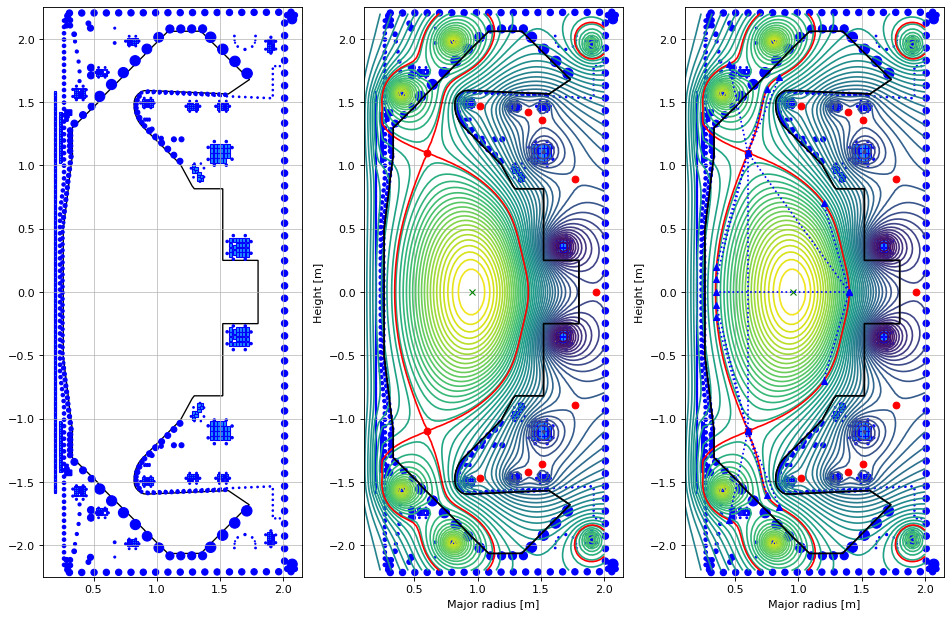

In [10]:
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8), dpi=80)

ax1.grid(zorder=0, alpha=0.75)
ax1.set_aspect('equal')
eq.tokamak.plot(axis=ax1,show=False)                                                          # plots the active coils and passive structures
ax1.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)   # plots the limiter
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)

ax2.grid(zorder=0, alpha=0.75)
ax2.set_aspect('equal')
eq.tokamak.plot(axis=ax2,show=False)                                                          # plots the active coils and passive structures
ax2.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)   # plots the limiter
eq.plot(axis=ax2,show=False)                                                                  # plots the equilibrium
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)


ax3.grid(zorder=0, alpha=0.75)
ax3.set_aspect('equal')
eq.tokamak.plot(axis=ax3,show=False)                                                          # plots the active coils and passive structures
ax3.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)   # plots the limiter
eq.plot(axis=ax3,show=False)                                                                  # plots the equilibrium
constrain.plot(axis=ax3, show=False)                                                          # plots the contraints
ax3.set_xlim(0.1, 2.15)
ax3.set_ylim(-2.25, 2.25)

plt.tight_layout()

A solve call will modify the equilibrium object in place. That means that certain quantities within the object will be updated as a result of the solve. 

Various different quantities and functions can be accessed via the 'eq' and 'profile' objects. For example:
- the total flux can be accessed with `eq.psi()`.
- the plasma flux with `eq.plasma_psi`.
- the active coil + passive structure flux with `eq.tokamak.psi(eq.R, eq.Z)`.
- (Total flux = plasma flux + coil flux)

Explore `eq.` to see more (also `profiles.`, e.g. the plasma current distribution over the domain can be found with `profiles.jtor`).

The set of optimised coil currents can be retrieved using `eq.tokamak.getCurrents()` having been assigned to the equilibrium object during the inverse solve.

The following lines will save the calculated currents to a pickle file. 

In [11]:
inverse_current_values = eq.tokamak.getCurrents()

# save coil currents to file
import pickle
with open('simple_diverted_currents_PaxisIp.pk', 'wb') as f:
    pickle.dump(obj=inverse_current_values, file=f)

### Example 2: the forward solver

As mentioned before, during a forward solve, we use fixed coil currents (as well as given profile functions/parameters) as inputs to solve for the equilibrium. 

To do this, we can use the set of currents we just identified during the inverse solve above. 

First, we instatiate a new equilibrium object and assign current values to the active coils in the tokamak (note that the passive structure currents are zero here).

In [12]:
# new equilibrium object
eq_forward = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # Radial range
    Zmin=-2.2, Zmax=2.2,  # Vertical range
    nx=65,                # Number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # Number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)  

# assign currents to the object
for key in inverse_current_values.keys():
    eq_forward.tokamak[key].current = inverse_current_values[key]

The syntax of a _forward_ solve is identical to that of an inverse call (i.e. calling `GSStaticSolver.solve()`), however the nonlinear solver is **not** provided with a `constrain` object (i.e. we set `constrain=None`). 

Therefore, coil current values are not modified during the solve but instead the solver uses them as inputs to calculate the equilibrium. 

The forward nonlinear static solver in FreeGSNKE uses a Newton-Krylov implementation (the inverse solver use Picard iterations), which allows considerably more restrictive tolerance requests when compared to inverse solves. 

In [13]:
# call the solver
GSStaticSolver.solve(eq=eq_forward, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

What we have done here is improve on the equilibrium found during the inverse solve by taking the coil currents (found during the inverse solve) and the same profile parameters and feeding them into the forward solver. 

We do this because it is often difficult to achieve low relative tolerances in _inverse_ solve calls (for example, the above was set at a loose target_relative_tolerance=1e-3) and so the strategy of using a forward solve after an inverse one is useful to obtain better (more converged) equilibria at stricter tolerances.

As an additional example, below we manually vary some of the coil currents, perform new forward solves and compare the resulting equilibria.
Note that the manual current changes cause one of the equilibria to transition from a diverted to a limiter configuration (this is handled through FreeGSfast).

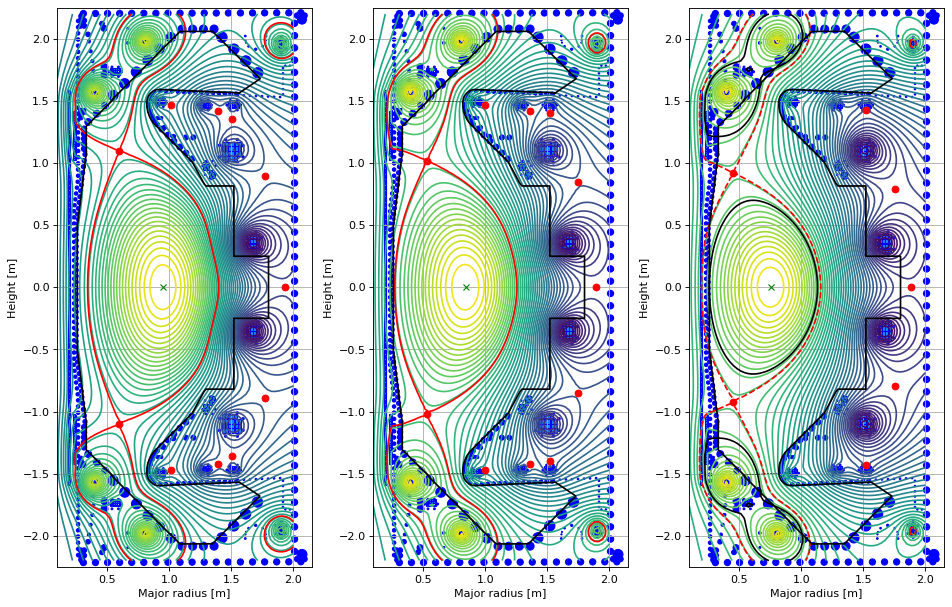

In [14]:
from copy import deepcopy

# copy the original eq object (for the new forward solves with modified currents)
eq_forward_1 = deepcopy(eq)
eq_forward_2 = deepcopy(eq)

# modify the P4 current and solve
eq_forward_1.tokamak['P4'].current *= 1.5
GSStaticSolver.solve(eq=eq_forward_1, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

# modify the P4 current (even more) and solve
eq_forward_2.tokamak['P4'].current *= 1.5**2
GSStaticSolver.solve(eq=eq_forward_2, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)


# plot the resulting equilbria 
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8), dpi=80)

# original 
ax1.grid(True, which='both')
eq_forward.plot(axis=ax1,show=False)
eq.tokamak.plot(axis=ax1,show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)

# modified 1
ax2.grid(True, which='both')
eq_forward_1.plot(axis=ax2,show=False)
eq.tokamak.plot(axis=ax2,show=False)
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)

# modified 2 (now limited plasma)
ax3.grid(True, which='both')
eq_forward_2.plot(axis=ax3,show=False)
eq.tokamak.plot(axis=ax3,show=False)
ax3.set_xlim(0.1, 2.15)
ax3.set_ylim(-2.25, 2.25)

plt.tight_layout()

Finally, we will illustrate how to use one of the other available profile objects: `ConstrainBetapIp`. All previous examples have used the profile object: `ConstrainPaxisIp`.

First, instantiate the new profile object.

In [15]:
from freegsnke.jtor_update import ConstrainBetapIp

profiles_beta = ConstrainBetapIp(
    eq=eq,
    limiter=tokamak.limiter,
    betap=0.05,
    Ip=6e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)

We can then use it directly in a new solve (with the coil currents found by the inverse solve).

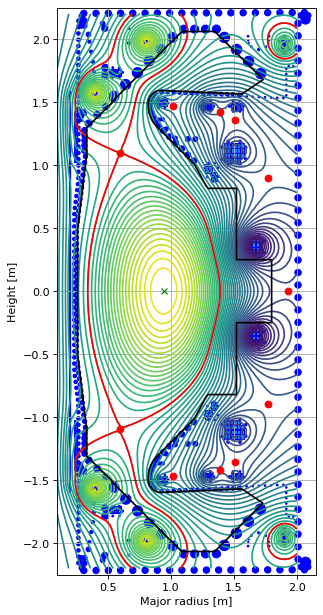

In [16]:
# instatiate new equilibrium object
eq_beta = deepcopy(eq_forward)

# call solver with new profile object
GSStaticSolver.solve(eq=eq_beta, 
                     profiles=profiles_beta, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)


# plot the resulting equilbria 
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq_beta.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

## Example 3: the forward solver (this time for a limited plasma)
We repeat parts of the example above for a plasma in a limited configuration. This requires use of FreeGSfast, please make sure that is correctly installed (it should be automatically installed with FreeGSNKE).

In a limiter configuration the plasma "touches" the limiter of the tokamak and is confined by the solid structures of the vessel. The last closed flux surface (LCFS) is the closed contour that is furthest from the magnetic axis that just barely touches (and is tangent to) the limiter.

Below we illustrate an inverse solve seeking coil current values for a limiter configuration. This is followed by a forward solve to improve the tolerance.

Rather than instantiating a new equilibrium we use one of the above. We also use the same profile object, but illustrate how to vary the total plasma current and pressure on axis.

In [17]:
# set some magnetic constraints
Rmid = 1.4   # Outboard midplane radius
Rin = 0.24   # Inboard midplane radius

# locations of X-points
Rx = 0.45
Zx = 1.18
xpoints = [(Rx, -Zx),   
           (Rx,  Zx)]

# isoflux constraints
isoflux = [
           (Rx,Zx, Rx,-Zx),
           (Rmid, 0, Rin, 0.0),
           (Rmid,0, Rx,Zx),
           (Rmid,0, 1.2,.7),
           (Rmid,0, 1.2,-.7),
           (Rx, Zx, .85, 1.7),
           (Rx, Zx, .75, 1.6),
           (Rx, Zx, Rin, 0.2),
           (Rx, Zx, Rin, 0.1),
           (Rx,-Zx, Rin, -0.1),
           (Rx,-Zx, Rin, -0.2),
           (Rx,-Zx, .85, -1.7),
           (Rx,-Zx, .75, -1.6),
           (Rx,-Zx, 0.45, -1.8),
           (Rx, Zx, 0.45,  1.8),
           ]

# let's seek an up-down symmetric equilibrium by imposing the current in P6 is zero
#eq.tokamak['P6'].current = 0
#eq.tokamak['P6'].control = False # fixes the current

# let's assume we're also seeking an equilibrium with no solenoid current
eq.tokamak['Solenoid'].current = 0
eq.tokamak['Solenoid'].control = False # fixes the current

# pass the magnetic constraints to a new constrain object
constrain = freegsfast.control.constrain(xpoints=xpoints,
                                         isoflux=isoflux,
                                         gamma=5e-6,
                                        )

# modify the total plasma current
profiles.Ip = 4e5

# modify the pressure on the magnetic axis
profiles.paxis = 6e3

# carry out the inverse solve (which finds the coil currents)
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-3)

# carry out the forward solve (which uses the currents found to obtain better converged equilibrium)
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

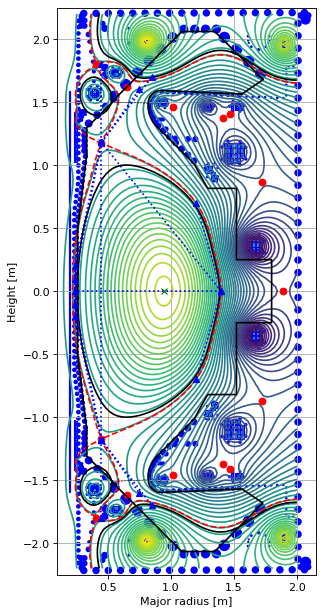

In [18]:
# plot the resulting equilbria 
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
constrain.plot(axis=ax1,show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

Now, let's assume we wish to set the solenoid current to 40000 Amperes. It is advisable to do so in stages as this is easier for the inverse solver to handle while avoiding non-recoverable configurations. 

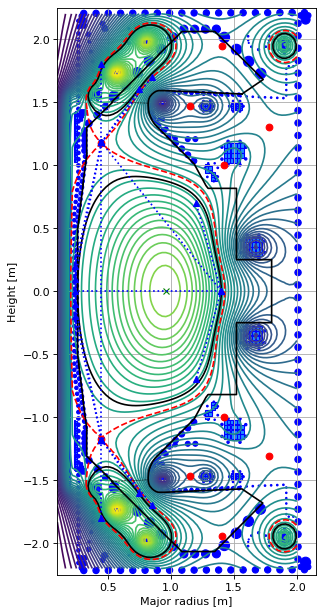

In [19]:
# we first raise the solenoid current to some intermediate value
# Note that `eq.tokamak['Solenoid'].control = False` is still set from above so we don't need it again
eq.tokamak['Solenoid'].current = 10000

# carry out a first inverse solve
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-3)

# raise the solenoid current further
eq.tokamak['Solenoid'].current = 40000

# carry out another inverse solve
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-3)

# now we're ready for a forward solve
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

# plot the resulting equilbria 
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
constrain.plot(axis=ax1,show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

### Example 4: Forward-solve from scratch, using saved currents (no inverse solve)
The example below does not assume the above has been executed, and can be run standalone in a new kernel.

Make sure, however, that the dictionary of currents has been correctly created using the example above itself.

No probe configuration is provided


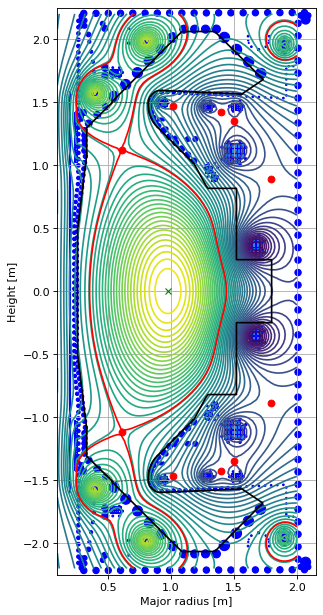

In [20]:
import matplotlib.pyplot as plt
import os

# set paths
os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U-like_active_coils.pickle"
os.environ["PASSIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U-like_passive_coils.pickle"
os.environ["WALL_PATH"] = f"../machine_configs/MAST-U/MAST-U-like_wall.pickle"
os.environ["LIMITER_PATH"] = f"../machine_configs/MAST-U/MAST-U-like_limiter.pickle"


# build machine
from freegsnke import build_machine
tokamak = build_machine.tokamak()

# initialise equilibrium object
from freegsnke import equilibrium_update
eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # Radial range
    Zmin=-2.2, Zmax=2.2,  # Vertical range
    nx=65,                # Number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # Number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)  

# initialise profile object
from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(
    eq=eq,
    limiter=tokamak.limiter,
    paxis=8.1e3,
    Ip=6.2e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)

# initialise solver
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

# set coil currents
import pickle
with open('simple_diverted_currents_PaxisIp.pk', 'rb') as f:
    current_values = pickle.load(f)
for key in current_values.keys():
    eq.tokamak[key].current = current_values[key]

# carry out forward solve
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

# plot the resulting equilbria 
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()